# Remove noisy background from images/documents using Auto-encoders, Tensorflow v2 and Keras

# What are Autoencoders?
Autoencoders are a type of artificial neural network architecture used in unsupervised machine learning and deep learning. They are primarily employed for dimensionality reduction, feature learning, and data compression tasks. Autoencoders consist of an encoder and a decoder, and their main goal is to learn a compressed representation (encoding) of input data and then reconstruct the original data from this representation.

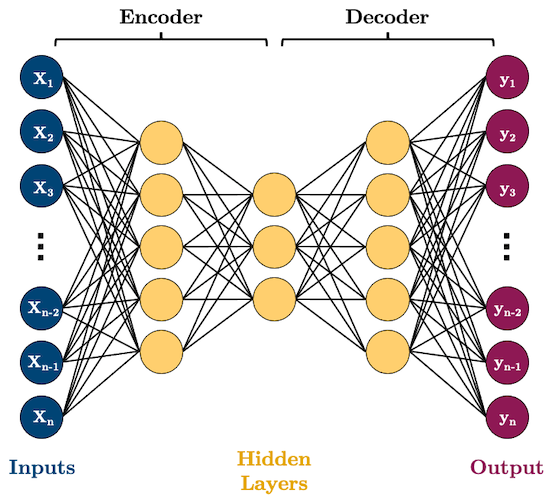

# Import libraries and data
First load libraries we need for our work. We need multiple libraries to be able to unzip files, work with directories, sklearn, tensorflow...

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input


%matplotlib inline

What kind of data/files we have there?

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/test.zip


As we have data zipped, we will have to work in /kaggle/working/ directory to unzip images here.

In [7]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

In [8]:
# unzip files first to working directory

for file in os.listdir(path_zip):
    with zipfile.ZipFile(path_zip + file,'r') as zip_file:
        zip_file.extractall(path)
        print(path+file)
    
    

/kaggle/working/train.zip
/kaggle/working/sampleSubmission.csv.zip
/kaggle/working/train_cleaned.zip
/kaggle/working/test.zip


For later use, we will store image names into list, so we can draw them simply.

In [9]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

# Data preprocessing


In [10]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

since the data is not that big we can just store the data into an array

In [11]:
# preprocess images
train = []
train_cleaned = []
test = []
# since train and train_cleaned have the same doc names we can embed them in one loop
for f in train_img:
    train.append(process_image(path + 'train/' + f))
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))

for f in test_img:
    test.append(process_image(path + 'test/' + f))

#  Visualizing Data
Let's take a look to our data

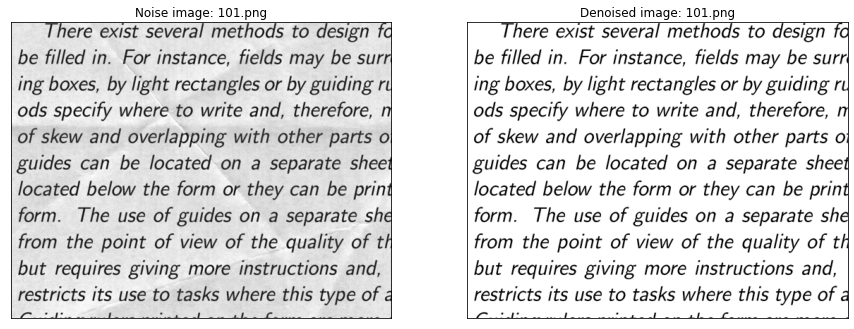

In [14]:
plt.figure(figsize=(15,25))

plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(train[0][:,:,0], cmap='gray')
plt.title('Noise image: {}'.format(train_img[0]))

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(train_cleaned[0][:,:,0], cmap='gray')
plt.title('Denoised image: {}'.format(train_img[0]))

plt.show()

# Split data
In this step we convert lists to numpy arrays and split dataset into train and validation in ration 85% train, 15% test.

In [10]:
# convert list to numpy array
X_train = np.array(train)
Y_train = np.array(train_cleaned)
X_test = np.array(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

# Modeling
Well I tried my best to make the model small as possible. As you will see the model did very well in the training process without BatchNorm or dropout so yea :D


In [11]:
def model():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder
model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)     

# Training 
I will just set the model to train for just 10 epochs to just test our apporach

In [12]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=8,  callbacks=[callback])

Epoch 1/10
16/16 [==============================] - 77s 5s/step - loss: 0.4331 - val_loss: 0.3698
Epoch 2/10
16/16 [==============================] - 77s 5s/step - loss: 0.3508 - val_loss: 0.3376
Epoch 3/10
16/16 [==============================] - 76s 5s/step - loss: 0.3156 - val_loss: 0.2755
Epoch 4/10
16/16 [==============================] - 76s 5s/step - loss: 0.2549 - val_loss: 0.2532
Epoch 5/10
16/16 [==============================] - 77s 5s/step - loss: 0.2331 - val_loss: 0.2219
Epoch 6/10
16/16 [==============================] - 76s 5s/step - loss: 0.2073 - val_loss: 0.1972
Epoch 7/10
16/16 [==============================] - 78s 5s/step - loss: 0.1899 - val_loss: 0.1844
Epoch 8/10
16/16 [==============================] - 77s 5s/step - loss: 0.1789 - val_loss: 0.1752
Epoch 9/10
16/16 [==============================] - 77s 5s/step - loss: 0.1708 - val_loss: 0.1695
Epoch 10/10
16/16 [==============================] - 77s 5s/step - loss: 0.1649 - val_loss: 0.1628


In [15]:
# Save the trained model to a file
model.save('my_trained_model.h5')


## Plot error evolution on epochs

You may notice jump in error after approx. 10 epoch that is pretty important, but enought epochs flatten this to almost 0.

# Evaluation
Let's see our results

In [13]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

Now compare noisy (left) and denoised test images (right). Our model has done great job with denoising!

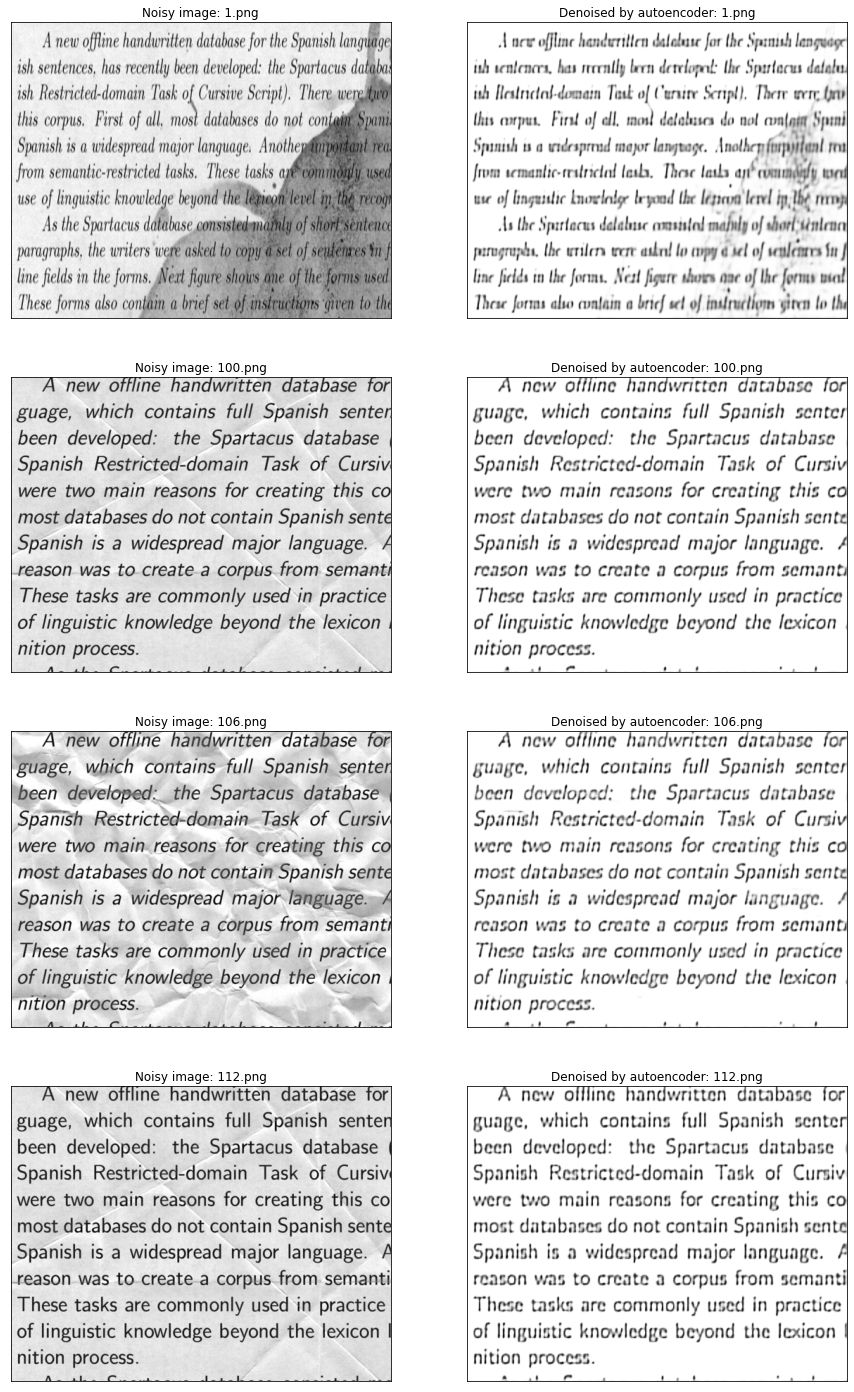

In [20]:

plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))
    # saving results for y
    cv2.imwrite(str(i)+'_Y.png', (Y_test[i] * 255).astype(np.uint8))

plt.show()

In [ ]:
# cleanup working directory
import shutil
shutil.rmtree(path + 'train/')
shutil.rmtree(path + 'test/')
shutil.rmtree(path + 'train_cleaned/')

I have really enjoyed this task, hope you did as well!